In [28]:
from datetime import datetime, timezone, timedelta

import hl
import numpy as np

end = datetime.now(timezone.utc)
start = end - timedelta(days=365*3)
df = hl.dl_ohlc_df('BTC', '1w', start, end)

df

,t,T,s,i,o,c,h,l,v,n
0,2022-12-29,2023-01-04 23:59:59.999,BTC,1w,16610.4,17124.7,17181.1,16541.2,0.0,0
1,2023-01-05,2023-01-11 23:59:59.999,BTC,1w,17124.6,20882.7,21544.0,17098.2,0.0,0
2,2023-01-12,2023-01-18 23:59:59.999,BTC,1w,20882.7,22704.6,23390.0,20386.0,0.0,0
3,2023-01-19,2023-01-25 23:59:59.999,BTC,1w,22704.7,23740.3,23962.7,22310.5,0.0,0
4,2023-01-26,2023-02-01 23:59:59.999,BTC,1w,23740.2,22929.2,24281.4,22484.2,0.0,0
...,...,...,...,...,...,...,...,...,...,...
152,2025-11-27,2025-12-03 23:59:59.999,BTC,1w,90421.0,93395.0,94140.0,83769.0,236068.5502,3474242
153,2025-12-04,2025-12-10 23:59:59.999,BTC,1w,93395.0,91961.0,94569.0,87666.0,232813.19625,2990227
154,2025-12-11,2025-12-17 23:59:59.999,BTC,1w,91961.0,86210.0,93544.0,85123.0,212301.69707,2819048
155,2025-12-18,2025-12-24 23:59:59.999,BTC,1w,86210.0,87653.0,90553.0,84395.0,203873.55675,2420979


In [29]:
df['close_log_return'] = np.log(df['c']/df['c'].shift(1))
df['close_log_return_lag_1'] = df['close_log_return'].shift(1)
df['close_log_return_lag_2'] = df['close_log_return'].shift(2)
df['close_log_return_lag_3'] = df['close_log_return'].shift(3)

In [30]:
log_returns = df[['close_log_return','close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']]
log_returns.corr()

,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
close_log_return,1.000000,-0.029793,0.112312,-0.018229
close_log_return_lag_1,-0.029793,1.000000,-0.029730,0.112086
close_log_return_lag_2,0.112312,-0.029730,1.000000,-0.028947
close_log_return_lag_3,-0.018229,0.112086,-0.028947,1.000000


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model = LinearRegression()

features = ['close_log_return_lag_1']
target = 'close_log_return'

df_train, df_test = train_test_split(df.dropna(), test_size = 0.25, shuffle=False)
X_train, X_test = df_train[features], df_test[features]
y_train, y_test = df_train[target], df_test[target]
model.fit(X_train, y_train)

print((model.coef_, model.intercept_))

y_hat = model.predict(X_test)

(array([-0.08265204]), np.float64(0.011897705694196684))


<Axes: >

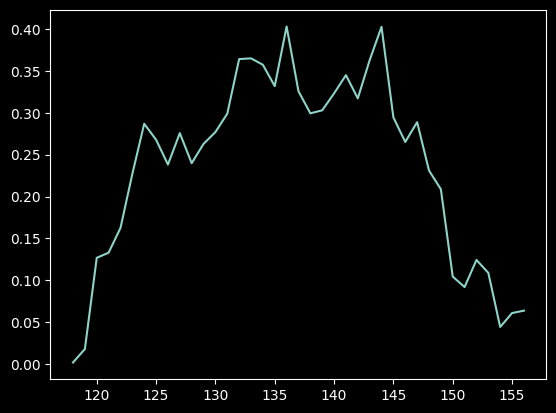

In [33]:
df_test['y_hat'] = y_hat
df_test['dir_signal'] = np.sign(y_hat)
df_test['trade_log_return'] = df_test['close_log_return'] * df_test['dir_signal']
df_test['cum_trade_log_return'] = df_test['trade_log_return'].cumsum()
df_test['cum_trade_log_return'].plot()